In [203]:
import torch
import numpy as np
import scipy.io as sio
import os

In [204]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [205]:
# Paramètres du modèle
N = 2 # dim de l'input x
m = 10 # dim de l'output y
T = 1 # borne sup pour x
nb_points = 10 
nb_maps = 100 # nombre d'images que l'on va générer
nb_blocks = 2 # nombre de blocs dans le modèle
M = 10 # nombre d'échantillons pour l'approximation de Monte Carlo

In [206]:
omega = torch.tensor([[0, 1] for _ in range(N)])
X = torch.zeros((nb_maps, nb_points, N), requires_grad=False)

for _ in range(nb_maps):
    x = torch.rand(nb_points, N, requires_grad=True) * (omega[:, 1] - omega[:, 0]) + omega[:, 0] # all the coordinates of x are between 0 and 1
    X[_, :, :] = x.detach().clone() # avoid in-place operation
X = torch.Tensor(np.expand_dims(X, axis=1))
X.requires_grad = True
print(f'La dimension de x est {x.size()}')

La dimension de x est torch.Size([10, 2])


In [207]:
class Block(torch.nn.Module):
    def __init__(self, m) -> None:
        super(Block, self).__init__()
        self.fc = torch.nn.Linear(m, m)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        identity = x
        x = self.fc(x)
        x = self.activation(x)
        x = self.fc(x)
        x = self.activation(x)
        return x + identity
    
class Model(torch.nn.Module):
    def __init__(self, N, m, nb_blocks) -> None:
        super(Model, self).__init__()
        self.fc_in = torch.nn.Linear(N, m)
        self.blocks = torch.nn.ModuleList([Block(m) for _ in range(nb_blocks)])
        self.fc_out = torch.nn.Linear(m, m)

    def forward(self, x):
        x = self.fc_in(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)
        return x

In [208]:
def conv(x : torch.Tensor, dx = True, delta : float = 1/nb_points) -> torch.Tensor:
    if dx:
        convx = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if j == 0 :
                    convx[i, j] = (x[i, j+1] - x[i, j])/delta # forward 
                elif j == x.shape[1] - 1:
                    convx[i, j] = (x[i, j] - x[i, j-1])/delta # backward
                else:
                    convx[i, j] = (x[i, j+1] - x[i, j-1])/(2*delta) # central
        return convx
    else:
        convy = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if i == 0 :
                    convy[i, j] = (x[i+1, j] - x[i, j])/delta # forward
                elif i == x.shape[0] - 1:
                    convy[i, j] = (x[i, j] - x[i-1, j])/delta # backward
                else:
                    convy[i, j] = (x[i+1, j] - x[i-1, j])/(2*delta) # central
        return convy
        
# def impose_BC(x : torch.Tensor) -> torch.Tensor:
#     x[:, -1] = torch.Tensor(np.cos(2 * np.pi * x[-1, :].detach().numpy()))
#     x[:, 0], x[0, :-1], x[-1, :-1] = 1., 1., 1.
#     return x

In [209]:
source_term = sio.loadmat('source_term.mat')
u = sio.loadmat('u.mat')

source_term = torch.Tensor(np.expand_dims(source_term['source_term'], axis=1))
u = torch.Tensor(np.expand_dims(u['u'], axis=1))

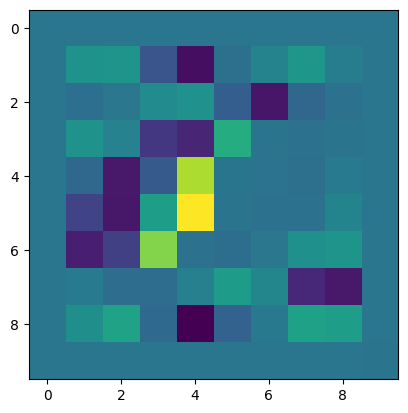

In [223]:
import matplotlib.pyplot as plt
plt.imshow(source_term[0, 0, :, :])

In [217]:
batch_size = 2
dataset = torch.utils.data.TensorDataset(X[0, 0, :, :], source_term[0, 0, :, :])
dataLoader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epochs = 1000

226.00674


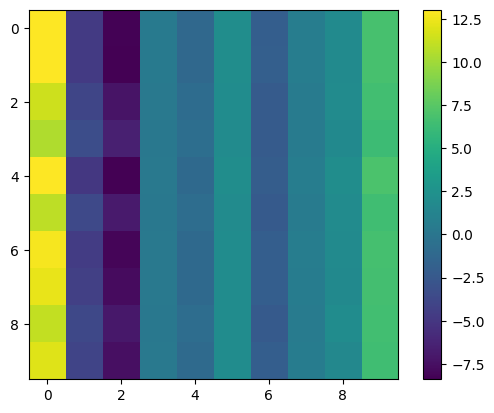

In [224]:
# Code simple pour une seule image
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999

gen = Model(N, m, nb_blocks)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
source_term_0 = impose_BC(source_term[0, 0, :, :])

cur_steps = 0

# output = gen(torch.rand(nb_points, N, requires_grad=True))

# while np.linalg.norm(output.detach().numpy() - source_term[0, 0, :, :].detach().numpy()) > 1e-1:
for epoch in range(num_epochs):
    gen.train()
    for x, source_term_0 in dataLoader : 
        output = gen(x)
        grad_output = torch.ones_like(output)
        grad_output = torch.autograd.grad(output, x, grad_output, create_graph=True, retain_graph=True)[0]

        # Monte Carlo
        mc_index = torch.randperm(2)[:M]
        output_mc = output[mc_index, :]
        source_term_mc = source_term_0[mc_index, :]
        grad_output_mc = grad_output[mc_index, :]

        # output_dx, output_dy = conv(output_mc), conv(output_mc, dx = False)
        # L1, L2 = torch.pow(output_dx, 2), torch.pow(output_dy, 2)
        # L1, L2 = torch.mean(L1), torch.mean(L2)
        L1 = torch.mean(grad_output_mc.square())
        L2 = torch.mean(source_term_mc*output_mc)
        
        loss = 0.5*L1 - L2
        
        gen_opt.zero_grad()
        loss.backward()
        gen_opt.step()
    gen.eval()
    cur_steps += 1

print(np.linalg.norm(gen(X[0, 0, :, :]).detach().numpy() - source_term[0, 0, :, :].detach().numpy()))

plt.imshow(gen(X[0, 0, :, :]).detach().numpy())
plt.colorbar()
plt.show()
# print(np.linalg.norm(output - source_term[0, 0, :, :]))

In [ ]:
# Code pour le tenseur complet
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999

gen = Model(N, m, nb_blocks)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

cur_steps = 0
# Monte Carlo
# for _ in range(10) :

output = gen(torch.rand(nb_maps, 1, nb_points, nb_blocks))

while np.linalg.norm(output.detach().numpy() - source_term.detach().numpy()) > 1e-1:
    gen_opt.zero_grad()
    
    output = gen(X)
    output_dX, output_dY = torch.zeros(output.shape), torch.zeros(output.shape)
    for i, out in enumerate(output) :
        output_dx, output_dy = conv(out[0]), conv(out[0], dx = False)
        output_dx, output_dy = output_dx.expand(1, 1, -1, -1), output_dy.expand(1, 1, -1, -1)
        output_dX[i, :, :, :], output_dY[i, :, :, :] = output_dx, output_dy

    L1, L2 = torch.pow(output_dX, 2), torch.pow(output_dY, 2)
    L1, L2 = torch.sum(L1)/(L1.shape[0]*L1.shape[1]), torch.sum(L2)/(L2.shape[0]*L2.shape[1])
    L3 = torch.sum(source_term*output) / (source_term.shape[0]*source_term.shape[1])

    loss = (L1 + L2)/2 - L3
    loss.backward()
    gen_opt.step()
    cur_steps += 1
    # print(f'Loss : {loss}')
    print(np.linalg.norm(output.detach().numpy() - source_term[0, 0, :, :].detach().numpy()))
plt.imshow(output.detach().numpy())
plt.show()
print(np.linalg.norm(output - source_term[0, 0, :, :]))

764.7393
764.7283
764.7172
764.7063
764.6954
764.6844
764.6736
764.6628
764.652
764.6411
764.6304
764.6196
764.60895
764.59827
764.58765
764.577
764.5664
764.55585
764.5452
764.5347
764.52423
764.5138
764.5033
764.49274
764.48236


KeyboardInterrupt: 

In [ ]:
gen = Model(N, m, nb_blocks)
output = gen(X)
output_dX, output_dY = torch.zeros(output.shape), torch.zeros(output.shape)

for i, out in enumerate(output) :
    output_dx, output_dy = conv(out[0]), conv(out[0], dx = False)
    output_dx, output_dy = output_dx.expand(1, 1, -1, -1), output_dy.expand(1, 1, -1, -1)
    output_dX[i, :, :, :], output_dY[i, :, :, :] = output_dx, output_dy
    
L1, L2 = torch.pow(output_dX, 2)/2, torch.pow(output_dY, 2)/2
# gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4)